In [1]:
import os
os.chdir("../system")

In [5]:
import visualize
import image_observers.YOLOv4.detector as yolo
from pathlib import Path
import importlib as imp
import pandas as pd
import seaborn as sns
import bbox
import matplotlib.pyplot as plt
import config.config
import undistort
from matplotlib.collections import LineCollection
import numpy as np
import cv2 as cv

In [3]:
imp.reload(visualize)
imp.reload(bbox)

<module 'bbox' from '/home/tal/dev/reptilearn/system/bbox.py'>

In [4]:
vid_path = Path('/data/reptilearn/experiments/yolo_first_one_20210419-152027/top_20210419-152613.mp4')

In [18]:
det = yolo.YOLOv4Detector(cfg_path='image_observers/YOLOv4/yolo4_2306.cfg', weights_path='image_observers/YOLOv4/yolo4_reptilearn260421_best.weights', return_neareast_detection=True)
det.load()

In [15]:
head_bbox_path = Path("/data/reptilearn/experiments/light_exp_try2_20210421-143906/head_bbox.csv")

In [16]:
head_bbox_df = pd.read_csv(str(head_bbox_path))

In [20]:
head_bbox_df[head_bbox_df['x1'].isna()].shape

(9251, 6)

In [21]:
head_bbox_df.shape

(92862, 6)

# Missing frames

In [ ]:
# 1st video - possibly bad focus
vid_path = Path('/data/reptilearn/experiments/yolo_first_one_20210419-152027/top_20210419-152613.mp4')

In [6]:
# 2nd video - possibly improved focus
vid_path = Path('/data/reptilearn/experiments/light_exp_try2_20210421-143906/top_20210421-143907.mp4')

In [176]:
# small example with aruco and nice pose
vid_path = Path('/data/reptilearn/media/new_house5_top_20210504-153111.mp4')

In [8]:
visualize.process_video(vid_path, None, [visualize.missed_frames_saver(det, "/home/tal/datasets/pogona_head_reptilearn/light_exp_try2_608", draw_bbox=False)])

  0%|          | 0/97788 [00:00<?, ?it/s]

## Paper Test

In [25]:
vid_path = Path('/data/reptilearn/experiments/d_20210616_155533/paper_test_top_20210616-155715.mp4')

1st video
---------
60295 missed / 159199 ! with 416x416
66198 missed / 159199 ! with 608x608 worse(?)

2nd video (some of the frames here are true negatives)
---------
25546 missed / 97788 with 416x416
23072 missed / 97788 with 608x608

# Analyze video  

In [26]:
bboxes = pd.DataFrame(columns=["x1", "y1", "x2", "y2", "conf"])

In [27]:
def detect_frame(orig_frame, write_frame, frame_counter):
    bbox = det.detect_image(orig_frame)
    bboxes.loc[bboxes.shape[0]] = bbox

In [28]:
visualize.process_video(vid_path, None, [detect_frame], start_frame=0, num_frames=None)

  0%|          | 0/2578 [00:00<?, ?it/s]

In [181]:
bboxes[bboxes['x1'].isna()].shape, bboxes.shape

((494, 5), (1357, 5))

## New weights (26.4.21)
1846/97788 misses on 2nd video (possibly all good because of true negatives)

In [29]:
visualize.process_video(vid_path, "../analysis/paper_test_ann.mp4", [
    visualize.offline_bbox_visualizer(bboxes.to_numpy(),window_size=1, line_thickness=4)
    ], num_frames=None)

  0%|          | 0/2578 [00:00<?, ?it/s]

# Heat map

In [134]:
undist_bboxes = undistort.undistort_data(bboxes, 1440, 1080, config.config.undistort_flir_blackfly_computar)

In [135]:
centroids = bbox.xyxy_to_centroid(undist_bboxes.to_numpy())
cent_df = pd.DataFrame(centroids, columns=["x", "y"])

In [51]:
cent_df

,x,y
0,699.625916,800.537725
1,699.518066,800.494488
2,699.510071,800.478394
3,699.494263,800.459129
4,699.639648,800.622602
...,...,...
97783,1261.934937,897.104971
97784,1262.551270,897.707645
97785,1262.228882,896.321980
97786,1262.062500,896.765205


In [175]:
%matplotlib widget
plt.clf()
ax = sns.histplot(cent_df, x="x", y="y", cbar=True, stat="probability", bins=(32, 18), color="red")
ax.set_title("Distribution over time")
ax.figure.set_dpi(100)
ax.figure.set_size_inches(9.2,4.8)
#ax.set_xlim(0, 1440)
#ax.set_ylim(0, 1080)
ax.invert_yaxis()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [170]:
fig.clf()
fig, ax = plt.subplots(1,1, dpi=100)
ax.add_collection(LineCollection((centroids,), alpha=0.35, linewidths=[1]))
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], s=1, color="red", zorder=100, alpha=0.2)
#ax.set_xlim(0, 1440)
#ax.set_ylim(0, 1080)
ax.invert_yaxis()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory over time")
ax.set_aspect(1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [160]:
xrange = np.nanmax(centroids[:, 0]) - np.nanmin(centroids[:, 0])
yrange = np.nanmax(centroids[:, 1]) - np.nanmin(centroids[:, 1])

In [172]:
fig.get_size_inches()

array([6.4, 4.8])

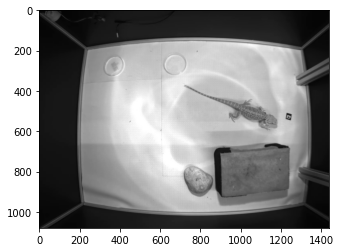

In [22]:
img_path = Path('/data/reptilearn/media/vlcsnap-2021-06-16-13h46m30s862.png')
img = cv.imread(str(img_path))
plt.imshow(img)

In [23]:
d = det.detect_image(img)

In [24]:
d

array([1.12429673e+03, 5.12867640e+02, 1.19091714e+03, 5.76503210e+02,
       9.88074124e-01])